# Simpson's Paradox
This notebook follows the famous example from *Causality* (Pearl, 2009).

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
from IPython.display import display, Math, Latex

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb


In a statistical study about a drug, we try to evaluate the latter's efficiency among a population of men and women.
Let's note:
- $Drug$ : drug taking
- $Patient$ : cured patient
- $Gender$ : patient's gender

The model from the observed date is as follow :

In [2]:
m1 = gum.fastBN("Gender{F|M}->Drug{Without|With}->Patient{Sick|Healed}<-Gender")

m1.cpt("Gender")[:]=[0.5,0.5]
m1.cpt("Drug")[:]=[[0.25,0.75],  #Gender=F
                   [0.75,0.25]]  #Gender=M

m1.cpt("Patient")[{'Drug':'Without','Gender':'F'}]=[0.2,0.8] #No Drug, Male -> healed in 0.8 of cases
m1.cpt("Patient")[{'Drug':'Without','Gender':'M'}]=[0.6,0.4] #No Drug, Female -> healed in 0.4 of cases
m1.cpt("Patient")[{'Drug':'With','Gender':'F'}]=[0.3,0.7] #Drug, Male -> healed 0.7 of cases 
m1.cpt("Patient")[{'Drug':'With','Gender':'M'}]=[0.8,0.2] #Drug, Female -> healed in 0.2 of cases
gnb.flow.row(m1,m1.cpt("Gender"),m1.cpt("Drug"),m1.cpt("Patient"))


In [3]:
def getCuredObservedProba(m1,evs):
    evs0=dict(evs)
    evs1=dict(evs)
    evs0["Drug"]='Without'
    evs1["Drug"]='With'
    
    return gum.Potential().add(m1.variableFromName("Drug")).fillWith([
            gum.getPosterior(m1,target="Patient",evs=evs0)[1],
            gum.getPosterior(m1,target="Patient",evs=evs1)[1]
        ])

gnb.sideBySide(getCuredObservedProba(m1,{}),
               getCuredObservedProba(m1,{'Gender':'F'}),
               getCuredObservedProba(m1,{'Gender':'M'}),
               captions=["$P(Patient = Healed \mid Drug )$<br/>Taking $Drug$ is observed as efficient to cure",
                         "$P(Patient = Healed \mid Gender=F,Drug)$<br/>except if the $gender$ of the patient is female",
                         "$P(Patient = Healed \mid Gender=M,Drug)$<br/>... or male."])


Those results form a paradox called <b>Simpson paradox</b> :

$$P(C\mid \neg{D}) = 0.5 < P(C\mid D) = 0.575$$
$$P(C\mid \neg{D},G = Male) = 0.8 > P(C\mid D,G = Male) = 0.7$$
$$P(C\mid \neg{D},G = Female) = 0.4 > P(C\mid D,G = Female) = 0.2$$

Actuallay, giving a drug is not an observation in our model but rather an intervention. What if we use intervention instead of observation ?

## How to compute causal impacts on the patient's health ?

We propose this causal model.

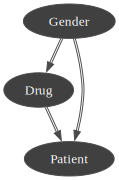

In [4]:
d1 = csl.CausalModel(m1)
cslnb.showCausalModel(d1)

### Computing $P (Patient = Healed \mid \text{do}(Drug = Without))$

In [5]:
cslnb.showCausalImpact(d1, "Patient", doing="Drug",values={"Drug" : "Without"})

We have, $P (Patient = Healed \mid \hookrightarrow Drug = without) = 0.6$

### Computing $P (Patient = Healed \mid \text{do}(Drug = With))$

In [6]:
d1 = csl.CausalModel(m1)
cslnb.showCausalImpact(d1, "Patient", "Drug",values={"Drug" : "With"})


And then : $P(Patient = Healed \mid \text{do}(Drug = With)) = 0.45 $

Therefore : $P(Patient = Healed\mid \text{do}(Drug = Without)) = 0.6 > P(Patient = Healed\mid \text{do}(Drug = With)) = 0.45 $

Which means that taking this drug would not enhance the patient's healing process, and it is better not to prescribe this drug for treatment.


## Simpson paradox solved by interventions

So to summarize, the paradox appears when wrongly dealing with observations on $Drug$ :

In [7]:
gnb.sideBySide(getCuredObservedProba(m1,{}),
               getCuredObservedProba(m1,{'Gender':'F'}),
               getCuredObservedProba(m1,{'Gender':'M'}),
               captions=["$P(Patient = Healed \mid Drug )$<br/>Taking $Drug$ is observed as efficient to cure",
                         "$P(Patient = Healed \mid Gender=F,Drug)$<br/>except if the $gender$ of the patient is female",
                         "$P(Patient = Healed \mid Gender=M,Drug)$<br/>... or male."])


... and disappears when dealing with intervention on $Drug$ :

In [8]:
gnb.sideBySide(csl.causalImpact(d1,on="Patient",doing="Drug",values={"Patient":"Healed"})[1],
               csl.causalImpact(d1,on="Patient",doing="Drug",knowing={"Gender"},values={"Patient":"Healed","Gender":"F"})[1],
               csl.causalImpact(d1,on="Patient",doing="Drug",knowing={"Gender"},values={"Patient":"Healed","Gender":"M"})[1],
               captions=["$P(Patient = 1 \mid \text{do}(Drug) )$<br/>Effectively $Drug$ taking is not efficient to cure",
                         "$P(Patient = 1 \mid \text{do}(Drug), gender=F )$<br/>, the $gender$ of the patient being female",
                         "$P(Patient = 1 \mid \text{do}(Drug), gender=M )$<br/>, ... or male."])
